**Chapter 3 – Classification**

_This notebook contains all the sample code and solutions to the exercises in chapter 3._

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [4]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.datasets import load_wine

# Common imports
import pandas as pd
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# wine

In [17]:
wine = load_wine(as_frame=True)
wine.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names'])

In [18]:
df = wine.data

In [19]:
df["target"] = wine.target

In [23]:
print(df["target"].value_counts())

# Transformando em class. binaria
df["target"] = np.where(df["target"] == 1, 1, 0)

print(df["target"].value_counts())

1    71
0    59
2    48
Name: target, dtype: int64
0    107
1     71
Name: target, dtype: int64


In [24]:
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


# Train Test Split

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
target = 'target'

# padrão 20% para teste
df_train, df_test = train_test_split(df,
                                     test_size = 0.2,
                                     random_state=75)

print("df.shape:      ",df.shape)
print("df_train.shape:",df_train.shape)
print("df_test.shape: ",df_test.shape)


X_train = df_train.drop(target, axis=1) # drop labels for training set
y_train = df_train[target].copy()

X_test = df_test.drop(target, axis=1) # drop labels for training set
y_test = df_test[target].copy()

print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)

df.shape:       (178, 14)
df_train.shape: (142, 14)
df_test.shape:  (36, 14)
X_train.shape: (142, 13)
y_train.shape: (142,)


# Teste HistGradientBoostingClassifier and HalvingRandomSearchCV

When using Gradient Descent, you should ensure that all features
have a **similar scale** (e.g., using Scikit-Learn’s StandardScaler
class), or else it will take much longer to converge.

In [27]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier

from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV, GridSearchCV

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [28]:
X_train.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
83,13.05,3.86,2.32,22.5,85.0,1.65,1.59,0.61,1.62,4.80,0.84,2.01,515.0
61,12.64,1.36,2.02,16.8,100.0,2.02,1.41,0.53,0.62,5.75,0.98,1.59,450.0
142,13.52,3.17,2.72,23.5,97.0,1.55,0.52,0.50,0.55,4.35,0.89,2.06,520.0
27,13.30,1.72,2.14,17.0,94.0,2.40,2.19,0.27,1.35,3.95,1.02,2.77,1285.0
62,13.67,1.25,1.92,18.0,94.0,2.10,1.79,0.32,0.73,3.80,1.23,2.46,630.0


In [29]:
# numeric_transformer
numeric_features = X_train.select_dtypes(include='number').columns # all numericals
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# categorical transformer
categorical_features = X_train.select_dtypes(include='object').columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])

# Preprocessor 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)],
        # MUITA Atenção aos argumentos do ColumnTransformer:
        remainder='passthrough',
        sparse_threshold=0.3,
        n_jobs=None,
        transformer_weights=None,
        verbose=False)

# GridSearch | RandomizedSearchCV
param_grid = [{"learning_rate" : [1] # Use 1 for no shrinkage.
               }, 
             ]
classifier = GradientBoostingClassifier() # HistGradientBoostingClassifier()

grid_search = GridSearchCV( #HalvingRandomSearchCV(
                            classifier,
                            param_grid = param_grid, #param_distributions=param_grid,
                            cv=5,
                            verbose=False,
                            refit=True)

prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', preprocessor),
    ('grid_search', grid_search)
])

In [30]:
prepare_select_and_predict_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preparation',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color_intensity', 'hue',
       'od...luted_wines', 'proline'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   Simp

# cross_val_predict

In [31]:
from sklearn.model_selection import cross_val_predict

y_scores     = cross_val_predict(prepare_select_and_predict_pipeline, X_train, y_train, cv=5, method='predict_proba')
y_train_pred = cross_val_predict(prepare_select_and_predict_pipeline, X_train, y_train, cv=5, method='predict')

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_train_pred)

array([[81,  3],
       [ 6, 52]])

# Precision Recall Curve

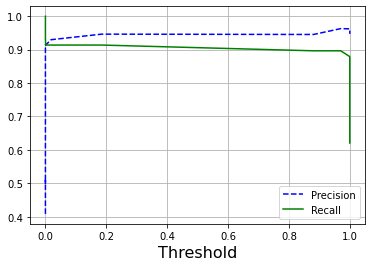

In [32]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores[:,1])

import matplotlib.pyplot as plt

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend() # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

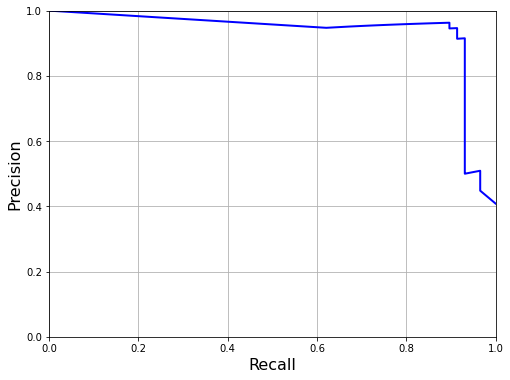

In [33]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

# ROC_AUC

In [34]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, y_scores[:,1])

0.9308292282430214

## Tresholds

0.1847533170480814


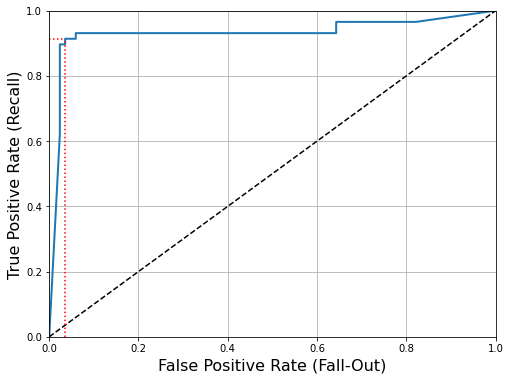

In [36]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train, y_scores[:,1])

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(optimal_threshold)

y_train_pred_treshold = np.where(y_scores[:,1] >= optimal_threshold,1,0)

tpr_opt = tpr[np.argmax(thresholds <= optimal_threshold)]
fpr_opt = fpr[np.argmax(thresholds <= optimal_threshold)]


def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

    
plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([fpr_opt, fpr_opt], [0., tpr_opt], "r:")   # Not shown
plt.plot([0., fpr_opt], [tpr_opt, tpr_opt], "r:")   # Not shown

plt.show()

### Comparando diferentes tresholds

In [37]:
confusion_matrix(y_train, y_train_pred)

array([[81,  3],
       [ 6, 52]])

In [38]:
confusion_matrix(y_train, y_train_pred_treshold)

array([[81,  3],
       [ 5, 53]])

# Importance